# Algoritmo de regresión logistica 

## Imports

In [1]:
# importamos las librerias y bibliotecas que utilizaremos para el algoritmo de regresión logistica
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

## Funciones auxiliares

In [2]:
# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

## Lectura del conjunto de datos

In [3]:
#Lectura del dataset 
df = pd.read_csv('dataset-equilibrado-3.csv')

##  Visualización preliminar de la información

In [4]:
# Vista de los datos cargados
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,72918,Female,53.0,1,0,Yes,Private,Urban,62.55,30.3,Unknown,1
1,72911,Female,57.0,1,0,Yes,Private,Rural,129.54,60.9,smokes,0
2,72898,Female,67.0,1,1,Yes,Private,Rural,199.24,33.9,never smoked,1
3,72882,Male,47.0,0,0,Yes,Private,Rural,75.30,25.0,formerly smoked,0
4,72861,Female,52.0,0,0,Yes,Private,Urban,69.30,20.1,never smoked,0


In [5]:
#Validamos la cantidad de ejemplos que posee el dataset
df["stroke"].value_counts()

0    1600
1     783
Name: stroke, dtype: int64

## Primera preparación del conjunto de datos

In [6]:
#Función para transformar las columnas categoricas a numericas
df_new = pd.get_dummies(df, columns=['gender','ever_married','work_type','Residence_type','smoking_status'])

In [7]:
#Validamos que los cambios se aplicarón correctamente 
df_new

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,72918,53.0,1,0,62.55,30.3,1,1,0,0,...,0,1,0,0,0,1,1,0,0,0
1,72911,57.0,1,0,129.54,60.9,0,1,0,0,...,0,1,0,0,1,0,0,0,0,1
2,72898,67.0,1,1,199.24,33.9,1,1,0,0,...,0,1,0,0,1,0,0,0,1,0
3,72882,47.0,0,0,75.30,25.0,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0
4,72861,52.0,0,0,69.30,20.1,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2378,132,80.0,0,0,84.86,NaN,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
2379,129,24.0,0,0,97.55,26.2,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0
2380,99,31.0,0,0,108.89,52.3,0,1,0,1,...,0,1,0,0,0,1,1,0,0,0
2381,84,55.0,0,0,89.17,31.5,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0


In [8]:
#Eliminamos datos que son irrelevantes y que podrian alterar el comportamiento del algoritmo
df_new = df_new.drop(["id"], axis=1)

## División del conjunto de datos

In [9]:
# Division del conjunto de datos en los diferentes subconjuntos
train_set, val_set, test_set = train_val_test_split(df_new, stratify='stroke')

In [10]:
#Verificamos las particiones realizadas
print("Longitud del Training Set:", len(train_set))
print("Longitud del Validation Set:", len(val_set))
print("Longitud del Test Set:", len(test_set))

Longitud del Training Set: 1429
Longitud del Validation Set: 477
Longitud del Test Set: 477


In [11]:
# Conjunto de datos de entrenamiento
X_train = train_set.drop("stroke", axis=1)
y_train = train_set["stroke"].copy()

In [12]:
# Conjunto de datos de validación
X_val = val_set.drop("stroke", axis=1)
y_val = val_set["stroke"].copy()

In [13]:
# Conjunto de datos de pruebas
X_test = test_set.drop("stroke", axis=1)
y_test = test_set["stroke"].copy()

## Segunda preparación del conjunto de datos

In [14]:
# Construcción de un pipeline para rellenar los valores nulos con la mediana y scalar los datos 
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('rbst_scaler', RobustScaler()),
    ])

In [15]:
# Rellenamos los valores nulos con la mediana y scalamos los datos
X_train_prep = num_pipeline.fit_transform(X_train)
X_val_prep = num_pipeline.fit_transform(X_val)
X_test_prep = num_pipeline.fit_transform(X_test)

In [16]:
# Transformamos el resultado a un DataFrame de Pandas
X_train_prep = pd.DataFrame(X_train_prep, columns=X_train.columns, index=y_train.index)
X_val_prep = pd.DataFrame(X_val_prep, columns=X_val.columns, index=y_val.index)
X_test_prep = pd.DataFrame(X_test_prep, columns=X_test.columns, index=y_test.index)

In [17]:
#Validamos que los cambios se aplicaron correctamente 
X_train_prep

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
2082,-0.315789,0.0,0.0,-0.197073,-0.141026,-1.0,1.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2367,-0.315789,0.0,0.0,2.230439,5.576923,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,1.0,0.0
118,0.289474,0.0,0.0,-0.727805,1.051282,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
959,0.184211,0.0,0.0,0.058341,-0.230769,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1592,-0.500000,0.0,0.0,0.232390,0.282051,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2370,-1.105263,0.0,0.0,-0.408780,-0.961538,0.0,0.0,1.0,-1.0,0.0,0.0,-1.0,0.0,1.0,1.0,-1.0,1.0,0.0,0.0,0.0
342,0.631579,0.0,0.0,-0.284488,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
39,-0.763158,0.0,0.0,0.821854,-0.141026,-1.0,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1486,-0.605263,0.0,0.0,-0.144195,0.948718,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Entrenamiento de un algoritmo de Regresión Logística

In [18]:
# Entrenamos un algoritmo basado en regresión logística
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, max_iter=350, solver='lbfgs').fit(X_train_prep, y_train)

## Predicción de nuevos ejemplos

In [19]:
y_pred = clf.predict(X_val_prep)

In [20]:
clf.score(X_val_prep, y_val)

0.8050314465408805

In [21]:
from sklearn.metrics import accuracy_score
print('Accuracy: {:.3f}'.format(accuracy_score(y_val, y_pred)))

Accuracy: 0.805


In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

array([[276,  44],
       [ 49, 108]], dtype=int64)

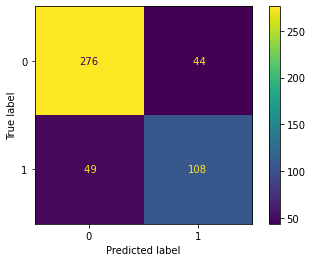

In [23]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_val_prep, y_val, values_format='3g')

## Métricas derivadas de la matriz de confusión

### Precisión

In [24]:
from sklearn.metrics import precision_score

print("Precisión:", precision_score(y_val, y_pred, pos_label=0))

Precisión: 0.8492307692307692


### Recall

In [25]:
from sklearn.metrics import recall_score

print("Recall:", recall_score(y_val, y_pred, pos_label=0))

Recall: 0.8625


### F1 Score

In [26]:
from sklearn.metrics import f1_score

print("F1 score:", f1_score(y_val, y_pred, pos_label=1))

F1 score: 0.6990291262135921


## Curvas ROC y PR

### Curva ROC

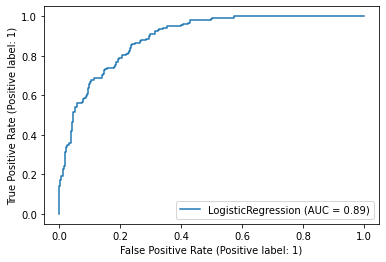

In [27]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(clf, X_val_prep, y_val)

### Curva PR

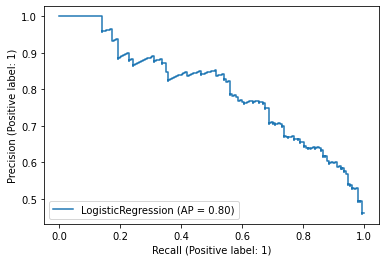

In [28]:
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(clf, X_val_prep, y_val)

## Evaluación del modelo con el conjunto de datos de pruebas

In [29]:
y_pred = clf.predict(X_test_prep)

In [30]:
clf.score(X_test_prep, y_test)

0.7819706498951782

In [31]:
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))

Accuracy: 0.782


In [32]:
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix

In [33]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[275  46]
 [ 58  98]]
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       321
           1       0.68      0.63      0.65       156

    accuracy                           0.78       477
   macro avg       0.75      0.74      0.75       477
weighted avg       0.78      0.78      0.78       477



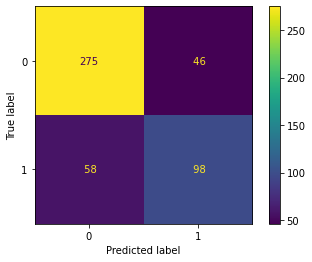

In [34]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_test_prep, y_test, values_format='3g')

## Métricas derivadas de la matriz de confusión

### Precisión

In [35]:
from sklearn.metrics import precision_score

print("Precisión:", precision_score(y_test, y_pred, pos_label=0))

Precisión: 0.8258258258258259


### Recall

In [36]:
from sklearn.metrics import recall_score

print("Recall:", recall_score(y_test, y_pred, pos_label=0))

Recall: 0.8566978193146417


### F1 Score

In [37]:
from sklearn.metrics import f1_score

print("F1 score:", f1_score(y_test, y_pred, pos_label=1))

F1 score: 0.6533333333333333


## Curvas ROC y PR

### Curva ROC

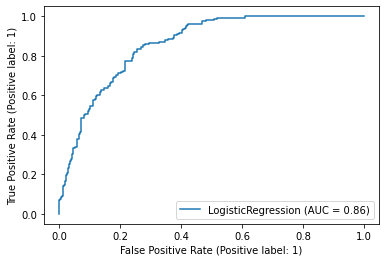

In [38]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(clf, X_test_prep, y_test)

### Curva PR

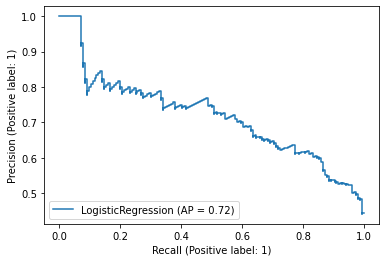

In [39]:
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(clf,X_test_prep, y_test)